In [1]:
# Imports
# pip install kagglehub[pandas-datasets]
#import kagglehub
#from kagglehub import KaggleDatasetAdapter
import os
import random
from glob import glob
import cv2 
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import numpy as np


import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

import argparse
#import torch
#import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from collections import Counter

# Dataset

### Conection to Kagglehub

In [ ]:
# Set the path to the file you'd like to load
#file_path = "sample_labels.csv"

# Load the latest version
#df = kagglehub.load_dataset(
#  KaggleDatasetAdapter.PANDAS,
#  "nih-chest-xrays/sample",
#  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
#)

#df.head()

C:\Users\giueg\AppData\Local\Temp\ipykernel_3636\1373790815.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [ ]:
# Download latest version
#path = kagglehub.dataset_download("nih-chest-xrays/sample")

#print("Path to dataset files:", path)

### Processing dataset

df_tcc_correct = sample_labels_tcc.csv

In [5]:
# data/images/
SOURCE_IMAGES = os.path.join("data", "images")

# ../input/sample/images/*.png
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

# Load labels
df_sample_labels = pd.read_csv('data/sample_labels.csv')
df_sample_labels.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


Number of images: 5606


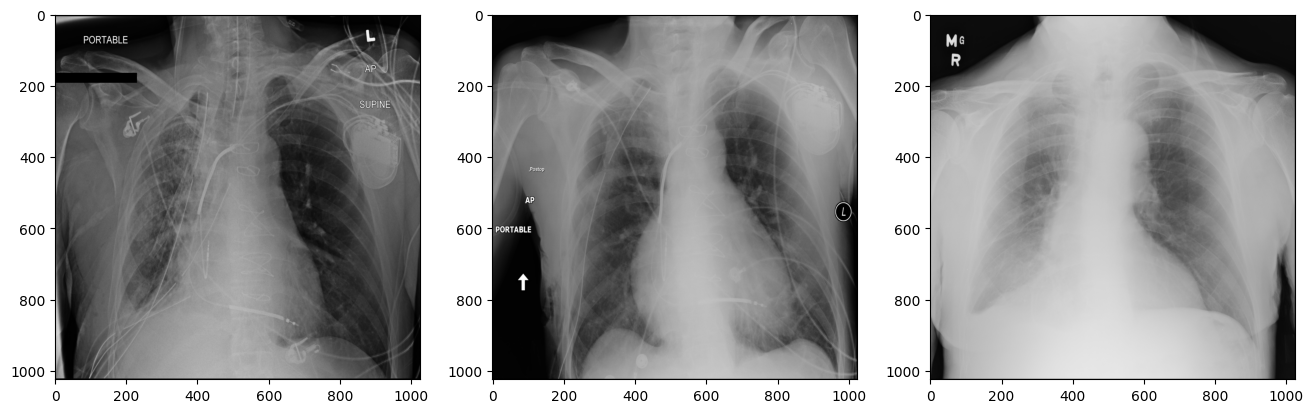

In [6]:
print("Number of images:", len(images))

# Matplotlib black magic
plt.figure(figsize=(16, 16))
plt.subplot(131)
plt.imshow(cv2.imread(images[0]))

plt.subplot(132)
plt.imshow(cv2.imread(images[1]))

plt.subplot(133)
plt.imshow(cv2.imread(images[2]))

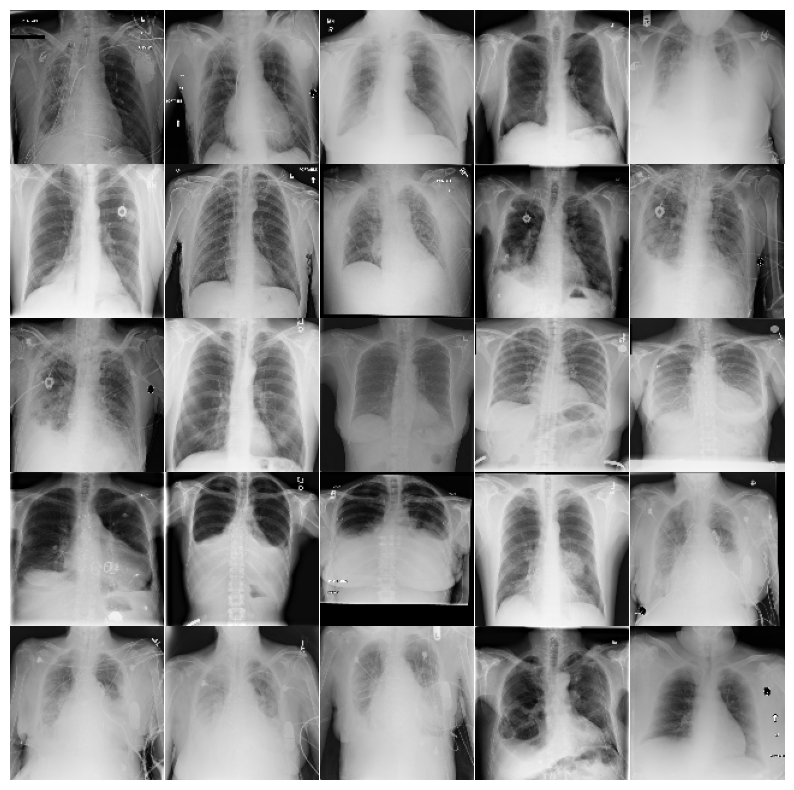

In [7]:
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in images[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [8]:
labels_counts = df_sample_labels['Finding Labels'].value_counts()
print(labels_counts.sum())
labels_counts

5606


Finding Labels
No Finding                                   3044
Infiltration                                  503
Effusion                                      203
Atelectasis                                   192
Nodule                                        144
                                             ... 
Cardiomegaly|Consolidation|Infiltration         1
Emphysema|Pleural_Thickening|Pneumothorax       1
Atelectasis|Consolidation|Effusion|Mass         1
Consolidation|Effusion|Pneumonia                1
Cardiomegaly|Effusion|Emphysema                 1
Name: count, Length: 244, dtype: int64

In [9]:
df_sample_labels[df_sample_labels['Finding Labels'] == 'Mass|Nodule'].value_counts()

Image Index       Finding Labels  Follow-up #  Patient ID  Patient Age  Patient Gender  View Position  OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y
00001836_076.png  Mass|Nodule     76           1836        050Y         F               AP             2500                2048                 0.168000                     0.168000                       1
00003503_000.png  Mass|Nodule     0            3503        066Y         F               PA             2048                2500                 0.171000                     0.171000                       1
00004574_000.png  Mass|Nodule     0            4574        068Y         M               PA             2500                2048                 0.171000                     0.171000                       1
00007405_002.png  Mass|Nodule     2            7405        054Y         M               AP             2500                2048                 0.168000                     0.168000

In [10]:
disease = ['Infiltration', 'Mass', 'Nodule', 'Mass|Nodule', 'No Finding']
df_tcc = df_sample_labels[df_sample_labels['Finding Labels'].isin(disease)]

df_tcc

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,0.139000
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,0.139000
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,0.139000
11,00000079_000.png,Mass,0,79,063Y,M,PA,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5600,00030704_000.png,No Finding,0,30704,052Y,F,PA,2021,2021,0.194311,0.194311
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


In [11]:
labels_counts_tcc = df_tcc['Finding Labels'].value_counts()
print(labels_counts_tcc.sum())
labels_counts_tcc

3807


Finding Labels
No Finding      3044
Infiltration     503
Nodule           144
Mass              99
Mass|Nodule       17
Name: count, dtype: int64

In [12]:
def rename_labels(label):
    if label == 'Mass|Nodule':
        return 'Neoplasia'
    elif label == 'Mass':
        return 'Neoplasia'
    elif label == 'Nodule':
        return 'Neoplasia'
    elif label == 'Infiltration':
        return 'Infection'
    elif label == 'No Finding':
        return 'Nothing'
    else:
        return label

df_tcc_correct = df_tcc.copy()

df_tcc_correct['Finding Labels'] = df_tcc['Finding Labels'].apply(rename_labels)

labels_counts_tcc_correct = df_tcc_correct['Finding Labels'].value_counts()
labels_counts_tcc_correct

Finding Labels
Nothing      3044
Infection     503
Neoplasia     260
Name: count, dtype: int64

Text(0.5, 0, 'Diagnóstico')

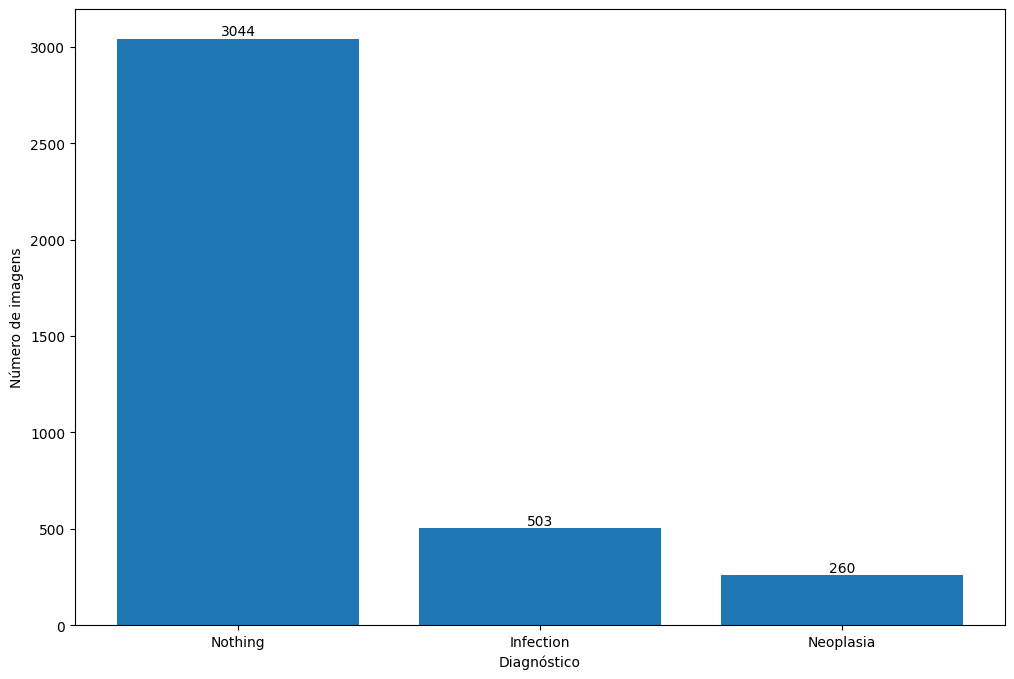

In [13]:
# Print the chart

fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
bar = ax1.bar(labels_counts_tcc_correct.index, labels_counts_tcc_correct.values)
ax1.bar_label(bar)

ax1.set_ylabel('Número de imagens')
ax1.set_xlabel('Diagnóstico')

In [14]:
df_tcc_correct.to_csv('data/sample_labels_tcc.csv', index=False)
df_tcc_correct

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2,00000017_001.png,Nothing,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
6,00000042_002.png,Nothing,2,42,071Y,M,AP,3056,2544,0.139000,0.139000
7,00000057_001.png,Nothing,1,57,071Y,M,AP,3056,2544,0.139000,0.139000
9,00000061_019.png,Nothing,19,61,077Y,M,AP,3056,2544,0.139000,0.139000
11,00000079_000.png,Neoplasia,0,79,063Y,M,PA,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5600,00030704_000.png,Nothing,0,30704,052Y,F,PA,2021,2021,0.194311,0.194311
5601,00030712_000.png,Nothing,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5603,00030789_000.png,Infection,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,Nothing,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


### Turn images into arrays

In [15]:
# Process images
def proc_images():
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """
    
    Neoplasia = "Neoplasia"
    Infection = "Infection"
    Nothing = "Nothing"

    x = [] # images as arrays
    y = [] # labels
    WIDTH = 128
    HEIGHT = 128

    for img in images:
        base = os.path.basename(img)
        filtered = df_tcc_correct[df_tcc_correct["Image Index"] == base]
        if filtered.empty:
            #print(f"Aviso: Imagem {base} não encontrada no DataFrame. Pulando...")
            continue

        finding = df_tcc_correct["Finding Labels"][df_tcc_correct["Image Index"] == base].values[0]

        # Read and resize image
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))

        # Labels
        if Neoplasia in finding:
            finding = 1
            y.append(finding)
        elif Infection in finding:
            finding = 2
            y.append(finding)
        elif Nothing in finding:
            finding = 0
            y.append(finding)
        else:
            continue

    return x,y

In [ ]:
# test
for img in images:
    base = os.path.basename(img)
    print(base)
    filtered = df_tcc_correct[df_tcc_correct["Image Index"] == base]
    if filtered.empty:
        print(f"Aviso: Imagem {base} não encontrada no DataFrame. Pulando...")
        continue

    finding = df_tcc_correct["Finding Labels"][df_tcc_correct["Image Index"] == base].values[0]
    print(finding)

00000013_005.png
Aviso: Imagem 00000013_005.png não encontrada no DataFrame. Pulando...
00000013_026.png
Aviso: Imagem 00000013_026.png não encontrada no DataFrame. Pulando...
00000017_001.png
Nothing
00000030_001.png
Aviso: Imagem 00000030_001.png não encontrada no DataFrame. Pulando...
00000032_001.png
Aviso: Imagem 00000032_001.png não encontrada no DataFrame. Pulando...
00000040_003.png
Aviso: Imagem 00000040_003.png não encontrada no DataFrame. Pulando...
00000042_002.png
Nothing
00000057_001.png
Nothing
00000061_002.png
Aviso: Imagem 00000061_002.png não encontrada no DataFrame. Pulando...
00000061_019.png
Nothing
00000061_025.png
Aviso: Imagem 00000061_025.png não encontrada no DataFrame. Pulando...
00000079_000.png
Neoplasia
00000080_005.png
Nothing
00000083_000.png
Nothing
00000084_000.png
Aviso: Imagem 00000084_000.png não encontrada no DataFrame. Pulando...
00000096_006.png
Aviso: Imagem 00000096_006.png não encontrada no DataFrame. Pulando...
00000099_003.png
Aviso: Imagem 

In [16]:
x,y = proc_images()

In [ ]:
df_images = pd.DataFrame()
df_images["labels"] = y 
df_images["images"] = x
print(len(df_images), df_images.images[0].shape)
#df_images.to_csv('data/df_images.csv', index=False)

3807 (128, 128, 3)


In [18]:
np.savez("data/x_images_arrays", x)
np.savez("data/y_labels_arrays", y)

### Prepare data to loader (run here to load data)

train_loader / val_loader / test_loader

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.uint8)
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [3]:
# Load the data(images)
x_npz = np.load("data/x_images_arrays.npz")
X = x_npz["arr_0"]
y_npz = np.load("data/y_labels_arrays.npz")
Y = y_npz["arr_0"]

print(np.array(X).shape) 
print(np.array(Y).shape)


(3807, 128, 128, 3)
(3807,)


In [4]:
# Separete the data into train, val and test sets
# 80% train, 10% val, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2,random_state=1, stratify=Y)

x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print(np.array(x_train).shape)
print(np.array(x_val).shape)
print(np.array(x_test).shape)
# (3045, 128, 128, 3)
# (381, 128, 128, 3)
# (381, 128, 128, 3)

(3045, 128, 128, 3)
(381, 128, 128, 3)
(381, 128, 128, 3)


In [5]:
# Transform the data to tensor
# Define a transform
transform = transforms.Compose([
            #transforms.Resize((28, 28)),
            transforms.ToPILImage(),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Apply the transform to the data
dataset_train = CustomImageDataset(x_train, y_train, transform=transform)
dataset_val = CustomImageDataset(x_val, y_val, transform=transform)
dataset_test = CustomImageDataset(x_val, y_val, transform=transform)

img, label = dataset_train[0]
print(img.shape, label) # [grayscale=1, size=128, size=128] label=0 ('Nothing')
print(dataset_train.__len__()) # 3045 images
print(dataset_val.__len__()) # 381 images
print(dataset_test.__len__()) # 381 images


torch.Size([1, 128, 128]) 0
3045
381
381


In [6]:
# Load into the DataLoader
batch_size = 32

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [7]:
# Verificar a distribuição de classes antes do SMOTE
print("Distribuição de classes no conjunto de treino (antes do SMOTE):")
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

# 0 -> nothing
# 1 -> neoplasia
# 2 -> infection

Distribuição de classes no conjunto de treino (antes do SMOTE):
Counter({np.int64(0): 2435, np.int64(2): 402, np.int64(1): 208})
Counter({np.int64(0): 304, np.int64(2): 51, np.int64(1): 26})
Counter({np.int64(0): 305, np.int64(2): 50, np.int64(1): 26})


In [14]:
dictionary_labels = {0: 'Nothing', 1: 'Neoplasia', 2: 'Infection'}
df_counter_train = pd.DataFrame(Counter(y_train).items(), columns=['label', 'values'])
df_counter_train['label'] = df_counter_train['label'].map(dictionary_labels)
df_counter_train = df_counter_train.sort_values(by='values', ascending=False)
print(df_counter_train)

df_counter_val = pd.DataFrame(Counter(y_val).items(), columns=['label', 'values'])
df_counter_val['label'] = df_counter_val['label'].map(dictionary_labels)
df_counter_val = df_counter_val.sort_values(by='values', ascending=False)
print(df_counter_val)

df_counter_test = pd.DataFrame(Counter(y_test).items(), columns=['label', 'values'])
df_counter_test['label'] = df_counter_test['label'].map(dictionary_labels)
df_counter_test = df_counter_test.sort_values(by='values', ascending=False)
print(df_counter_test)



       label  values
0    Nothing    2435
1  Infection     402
2  Neoplasia     208
       label  values
0    Nothing     304
2  Infection      51
1  Neoplasia      26
       label  values
1    Nothing     305
0  Infection      50
2  Neoplasia      26


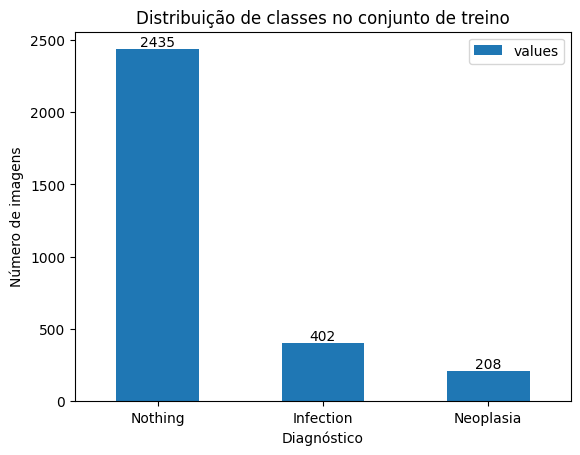

In [19]:
df_counter_train.plot(kind='bar', x='label', y='values', title='Distribuição de classes no conjunto de treino')
plt.xlabel('Diagnóstico')
plt.ylabel('Número de imagens')
plt.xticks(rotation=0)
#coloca valor na coluna
for index, value in enumerate(df_counter_train['values']):
    plt.text(index, value, str(value), ha='center', va='bottom')

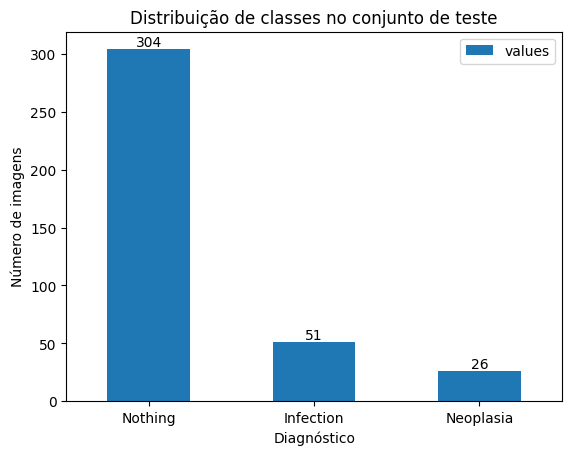

In [21]:
df_counter_val.plot(kind='bar', x='label', y='values', title='Distribuição de classes no conjunto de teste')
plt.xlabel('Diagnóstico')
plt.ylabel('Número de imagens')
plt.xticks(rotation=0)
#coloca valor na coluna
for index, value in enumerate(df_counter_val['values']):
    plt.text(index, value, str(value), ha='center', va='bottom')

# SnnTorch

### Spike Encoding

In [8]:
# Test spike generation
num_steps = 50
data = iter(train_loader)
data_it, target_it = next(data)

spike_data_R = spikegen.rate(data_it, num_steps=num_steps)
print(f"Spike data size (rate): {spike_data_R.size()}")

#spike_data_L = spikegen.latency(data_it, num_steps=num_steps, tau=5, threshold=0.01)
#print(f"Spike data size (latency): {spike_data_L.size()}")

spike_data_L_2 = spikegen.latency(data_it, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)
print(f"Spike data size (latency 2): {spike_data_L_2.size()}")

spike_data_D = spikegen.delta(data_it, threshold=1, off_spike=True)
print(f"Spike data size (delta): {spike_data_D.size()}")

Spike data size (rate): torch.Size([50, 32, 1, 128, 128])
Spike data size (latency 2): torch.Size([50, 32, 1, 128, 128])
Spike data size (delta): torch.Size([32, 1, 128, 128])


### Network (SNN)

#### Define

In [ ]:
# Define the network

# Already defined in the previous cell
# batch_size = 32
# train_loader / val_loader / test_loader
num_steps = 50

dtype = torch.float
# Use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Network Architecture
num_inputs = 128*128
num_hidden = 1000
num_outputs = 3 # classes

# Temporal Dynamics
# num_steps = 25
beta = 0.95

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta) # trocar por relu 
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta) # trocar por relu

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x[step].view(-1, num_inputs))
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
    

# Load the network onto CUDA if available
net = Net().to(device)

In [4]:
# Metrics
# Accuracy
# pass data into the network, sum the spikes over time
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(spike_data, targets, train=True)
    print_batch_accuracy(test_spike_data, test_targets, train=False)
    print("\n")

# loss
loss = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

#### Test: One iteration

In [12]:
# One iteration of training

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

spike_data = spikegen.latency(data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)
print(f"Spike data size (latency 2): {spike_data.size()}")

spk_rec, mem_rec = net(spike_data)
print(mem_rec.size()) 
# torch.Size([50, 32, 3])

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)
  
print(f"Training loss: {loss_val.item():.3f}")
# Training loss: 39.970

print_batch_accuracy(spike_data, targets, train=True)
# Train set accuracy for a single minibatch: 87.50%

Spike data size (latency 2): torch.Size([50, 32, 1, 128, 128])
torch.Size([50, 32, 3])
Training loss: 65.281
Train set accuracy for a single minibatch: 78.12%


In [13]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

# calculate new network outputs using the same data
spk_rec, mem_rec = net(spike_data)

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}") # Training loss: 42.026
print_batch_accuracy(spike_data, targets, train=True) # Train set accuracy for a single minibatch: 87.50%

Training loss: 66.070
Train set accuracy for a single minibatch: 78.12%


#### Training loop

In [ ]:
# Training loop
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spike_data = spikegen.latency(data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)
        #print(f"Spike data size (latency 2): {spike_data.size()}")

        spk_rec, mem_rec = net(spike_data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            test_spike_data = spikegen.latency(test_data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)

            # Test set forward pass
            test_spk, test_mem = net(test_spike_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 32 == 0:
                train_printer()
            counter += 1
            iter_counter +=1
    
# Epoch 0, Iteration 0
# Train Set Loss: 48.70
# Test Set Loss: 99.25
# Train set accuracy for a single minibatch: 87.50%
# Test set accuracy for a single minibatch: 75.00%


# Epoch 0, Iteration 32
# Train Set Loss: 28.19
# Test Set Loss: 42.33
# Train set accuracy for a single minibatch: 87.50%
# Test set accuracy for a single minibatch: 71.88%


# Epoch 0, Iteration 64
# Train Set Loss: 41.60
# Test Set Loss: 30.56
# Train set accuracy for a single minibatch: 71.88%
# Test set accuracy for a single minibatch: 84.38%

Epoch 0, Iteration 0
Train Set Loss: 53.42
Test Set Loss: 107.44
Train set accuracy for a single minibatch: 87.50%
Test set accuracy for a single minibatch: 75.00%


Epoch 0, Iteration 32
Train Set Loss: 35.77
Test Set Loss: 34.06
Train set accuracy for a single minibatch: 81.25%
Test set accuracy for a single minibatch: 84.38%


Epoch 0, Iteration 64
Train Set Loss: 39.83
Test Set Loss: 42.80
Train set accuracy for a single minibatch: 75.00%
Test set accuracy for a single minibatch: 68.75%




#### Metrics

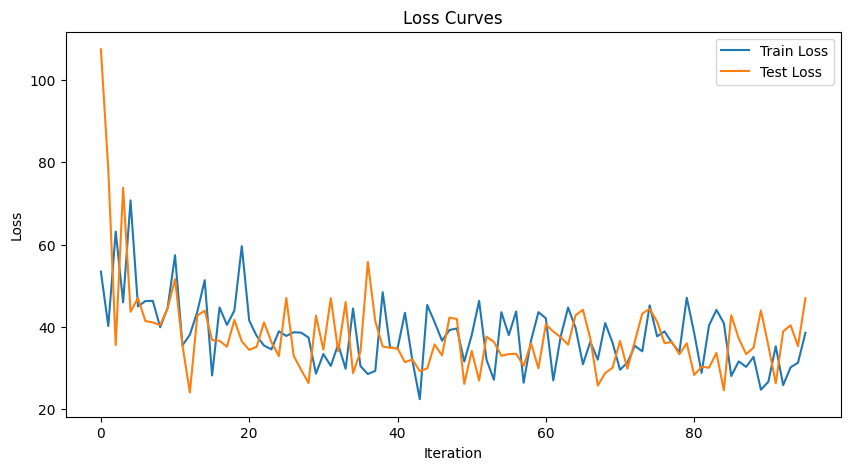

In [17]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [19]:
total = 0
correct = 0

test_loader

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    spike_data = spikegen.latency(data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)

    test_spk, _ = net(spike_data)

    # forward pass
    test_spk, _ = net(spike_data)

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()
    
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
# Total correctly classified test set images: 304/381 -> Usar o F1 SCORE
# Test Set Accuracy: 79.79%

Total correctly classified test set images: 304/381
Test Set Accuracy: 79.79%


In [ ]:
# Test more metrics
def calculate_metrics(y_true, y_pred):
    """
    Calculates precision, recall, and F1-score.
    
    Args:
        y_true (list or numpy.ndarray): Ground truth (correct) target values.
        y_pred (list or numpy.ndarray): Estimated target values.
        
    Returns:
        precision (float): Precision score.
        recall (float): Recall score.
        f1 (float): F1-score.
    """
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    return precision, recall, f1


# Example usage
y_true = [0, 1, 0, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]

precision, recall, f1 = calculate_metrics(y_true, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Precision: 0.67
Recall: 0.67
F1-score: 0.67


In [22]:
# Código extra para salvar o modelo
PATH = './models/snnv1.pth'
torch.save(net.state_dict(), PATH)
print(f"Modelo salvo com sucesso em: {PATH}")

Modelo salvo com sucesso em: ./models/snnv1.pth


In [4]:
# Carregar o modelo salvo
PATH = './models/snnv1.pth'
net.load_state_dict(torch.load(PATH))
net.eval()  # Colocar o modelo em modo de avaliação
print(f"Modelo carregado com sucesso de: {PATH}")

Modelo carregado com sucesso de: ./models/snnv1.pth


In [13]:
# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro') # average = 'weighted' | 'micro' | 'macro'
    return precision, recall, f1

# Listas para armazenar previsões e rótulos verdadeiros
all_preds = []
all_targets = []

# Avaliação do modelo
total = 0
correct = 0

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        # Converter dados para spikes
        spike_data = spikegen.latency(data, num_steps=num_steps, tau=1, threshold=0.001, clip=True, normalize=True, linear=True)

        # Forward pass
        test_spk, _ = net(spike_data)

        # Previsões
        _, predicted = test_spk.sum(dim=0).max(1)

        # Acumular acurácia
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Armazenar previsões e rótulos para F1 e matriz de confusão
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Calcular acurácia
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

# Calcular precisão, recall e F1-score
precision, recall, f1 = calculate_metrics(all_targets, all_preds) 
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Calcular e exibir a matriz de confusão
conf_matrix = confusion_matrix(all_targets, all_preds)
print("\nMatriz de Confusão:")
print(conf_matrix)

Total correctly classified test set images: 304/381
Test Set Accuracy: 79.79%
Precision: 0.27
Recall: 0.33
F1-score: 0.30

Matriz de Confusão:
[[304   0   0]
 [ 26   0   0]
 [ 51   0   0]]


c:\Users\giueg\.virtualenvs\TCC_25-OGy0qkdu\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


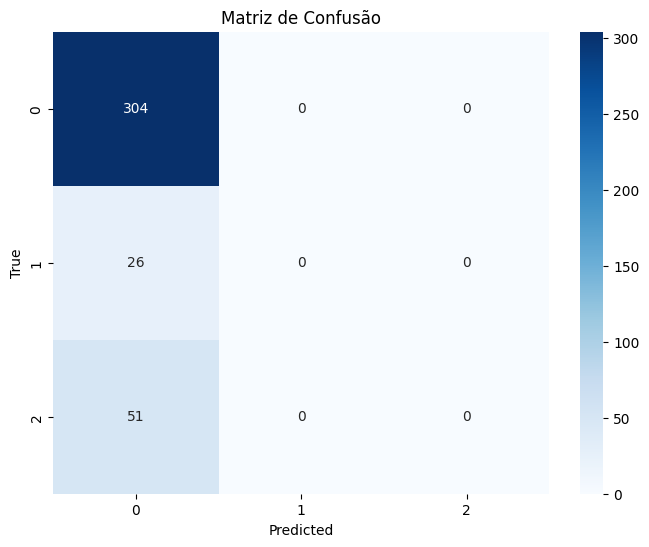

In [14]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()